In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import itertools
from random import shuffle

In [35]:
plt.style.use('seaborn-talk')
matplotlib.rcParams.update({'font.size': 15})

In [26]:
print(plt.style.available)

['seaborn-darkgrid', 'ggplot', 'seaborn-poster', 'seaborn-notebook', 'seaborn-ticks', 'classic', 'Solarize_Light2', 'grayscale', 'seaborn', 'seaborn-dark-palette', 'seaborn-talk', 'seaborn-dark', 'seaborn-paper', 'seaborn-deep', 'seaborn-white', 'seaborn-pastel', 'seaborn-muted', 'fivethirtyeight', '_classic_test', 'seaborn-colorblind', 'seaborn-bright', 'fast', 'seaborn-whitegrid', 'dark_background', 'bmh']


In [13]:
# Path to the cleaned data
data_path="C://Users//Dimitri//Desktop//ENSAE3A//Apprentissage en ligne//OnlinePortfolio//TreatedData//DataNyse.csv"
# Location to use to save outputs
output_path = "C://Users//Dimitri//Desktop//ENSAE3A//Apprentissage en ligne//OnlinePortfolio//Outputs//"
# Frequence of rebalancing the portfolio
ndays_rebal = 30
# Eta parameter
eta = 2

In [53]:
# Load the data
data_nyse = pd.read_csv(data_path, index_col="Date")
# Convert data index to datetime
data_nyse.index = pd.to_datetime(data_nyse.index)
# Print the data for a quick check
print(data_nyse)

               nwl     fhn       cmi     cma     wfc     cms      ups     nem  \
Date                                                                            
2001-09-21  17.690  29.537    6.4215  43.127  16.944  15.085   40.068  19.856   
2001-09-24  18.018  29.955    6.8668  44.278  17.225  15.085   40.161  19.260   
2001-09-25  18.181  30.751    6.9695  45.840  17.372  14.887   41.359  19.565   
2001-09-26  18.392  31.850    6.7469  45.112  17.423  14.494   39.861  20.832   
2001-09-27  18.852  32.147    6.8838  45.967  17.431  14.287   40.083  21.083   
2001-09-28  18.945  32.113    7.0640  46.753  17.735  14.368   41.900  21.039   
2001-10-01  19.075  31.814    6.8754  46.376  17.735  14.368   40.826  22.134   
2001-10-02  19.347  32.331    7.1667  45.744  17.796  14.454   40.387  21.891   
2001-10-03  19.895  31.859    7.2006  45.608  17.859  14.793   41.195  20.581   
2001-10-04  19.903  30.760    7.2605  45.325  17.654  15.085   41.917  20.562   
2001-10-05  20.112  29.935  

In [54]:
# Get the returns for every ndays_rebal and select only every ndays_rebal-th date
data_returns = data_nyse.pct_change(ndays_rebal).ix[::ndays_rebal, :]
data_returns = data_returns.shift(-1)
data_returns.dropna(how="any", axis=0, inplace=True)
print(data_returns.shape)

(137, 256)


## Wealth factor
The following function computes the wealth factor of a strategy determined by a set of weigths $q_{i, t}$. Let $x_{i, t}$ be the returns, $N$ the number of assets and $n$ the number of periods, the wealth factor is given by :
$$ \prod_{t=1}^n \sum_{i=1}^N x_{i, t} q_{i, t} $$

In [5]:
def wealth_factor(q, x, n):
    """
    Compute the wealth factor for a given strategy q
    
    Args:
        x (pandas.core.frame.DataFrame) : the dataframe of 1 + returns
        q (pandas.core.frame.DataFrame) : the weights for the strategy
        n (int) : number of periods to compute the wealth factor on
    Returns:
        float. The wealth factor for the strategy q
    """
    wealth_coefs = (x * q).sum(axis=1)
    log_wealth_coefs = wealth_coefs.apply(np.log)
    log_wealth_factor = log_wealth_coefs.cumsum()
    return np.exp(log_wealth_factor)

## Internal regret

In [6]:
def switched_strategy(pvec, i, j):
    """
    Compute the i to j transformed strategy weight vector
    
    Args:
        pvec (pandas.core.series.Series) : the original weight vector
        i (str) : the stock which weight should be allocated to j
        j (str) : the stock keeping its weight and getting i's moreover
    Returns:
        pandas.core.series.Series. The modified weight vector
    """
    switched = pvec.copy()
    switched[j] += switched[i] 
    switched[i] = 0
    return switched

In [7]:
def no_switch_regret(pvec, xvec, i, j):
    """
    Compute the i to j component to regret for a single vector
    
    Args:
        pvec (pandas.core.series.Series) : the original weight vector
        xvec (pandas.core.series.Series) : the vector of 1 + returns
        i (str) : the stock which weight should be allocated to j
        j (str) : the stock keeping its weight and getting i's moreover
    Returns:
        float. The regret component
    """
    switched = switched_strategy(pvec, i, j)
    return np.log((switched * xvec).sum()) -  np.log((pvec * xvec).sum())

In [8]:
def pairs_of_stocks(p):
    stocks_pairs = list(itertools.product(p.columns, p.columns))
    stocks_pairs_str = []
    for pair in stocks_pairs:
        if pair[0] != pair[1]:
            stocks_pairs_str.append(pair[0] + "/" + pair[1])
    return stocks_pairs_str

In [9]:
def no_switch_regret_tab(p, x):
    stocks_pairs_str = pairs_of_stocks(p)
    regret_tab = pd.DataFrame(index=p.index, columns=stocks_pairs_str)
    for t in p.index:
        for pair in stocks_pairs_str :
            stock1, stock2 = pair.split("/")[0], pair.split("/")[1]
            regret_tab.loc[t, pair] = no_switch_regret(p.loc[t, :], x.loc[t, :], stock1, stock2)
    return regret_tab

In [10]:
def internal_regret_tab(p, x):
    r_tab = no_switch_regret_tab(p, x).cumsum().max(axis=1)
    return r_tab

## Exp weights coefs
For a given set of weights at time $t-1$, will compute the vector of actualization of the weights at time $t$ which is given by the components :
$$ \frac{p_{i, t} \exp \left( \frac{\eta x_{i, t}} {p_t x_t} \right)}{\sum_{j=1}^N p_{j, t} \exp \left( \frac{\eta x_{j, t}} {p_t x_t} \right)} $$

In [11]:
def exp_weights(pvec, xvec, eta):
    """
    Computes the vector of actualization of the weights for the EG strategy
    
    Args:
        pvec (pandas.core.series.Series) : the vector of previous weights
        xvec (pandas.core.series.Series) : the vector of previous 1 + returns
        eta (float) : eta parameter
    Returns:
        pandas.core.series.Series. The vector of actualization of weights for the EG strategy
    """
    norm_coef = (pvec * xvec).sum()
    wvec = pd.Series(index=pvec.index)
    for i in pvec.index:
        wvec[i] = pvec[i] * np.exp (eta * xvec[i] / norm_coef)
    return wvec / wvec.sum()

In [12]:
def weights_eg(xtab, eta, pinit):
    """
    Compute the weights for the EG strategy
    
    Args:
        xtab (pandas.core.frame.DataFrame) : the data frame of returns
        eta (float) : the eta parameter
        pinit (pandas.core.series.Series) : the series of initial weights, we must have pinit.index = xtab.columns
    """
    wtab = pd.DataFrame(index=xtab.index, columns=xtab.columns)
    for t in range(0, wtab.shape[0]):
        if t==0:
            wtab.iloc[t, :] = pinit
        else :
            coefs = exp_weights(wtab.iloc[t-1, :], xtab.iloc[t-1, :], eta)
            wtab.iloc[t, :] = coefs
    return wtab

(137, 5)


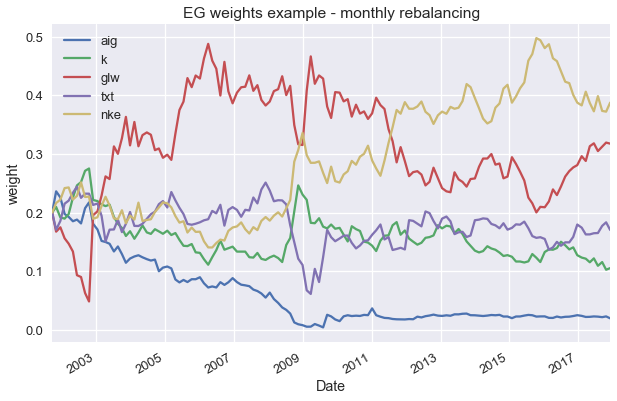

In [44]:
# Test for weights_eg
x = 1 + data_returns.iloc[:, 10:15]
pinit = pd.Series(index=x.columns, data=1/len(x.columns))
w = weights_eg(x, 1, pinit)
fig, ax = plt.subplots(1, 1, figsize=(10.0, 6.5))
w.plot(ax=ax)
plt.title("EG weights example - monthly rebalancing")
plt.ylabel("weight")
fig.savefig(output_path + "EG_weights_example.svg")
plt.show()

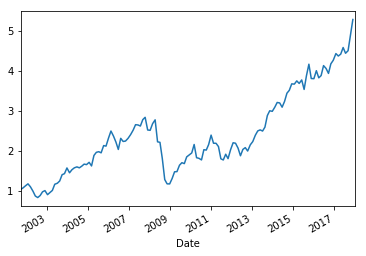

In [14]:
# Test for wealth factor on the EG strategy
w_fact = wealth_factor(x, w, 10)
w_fact.plot()
plt.show()

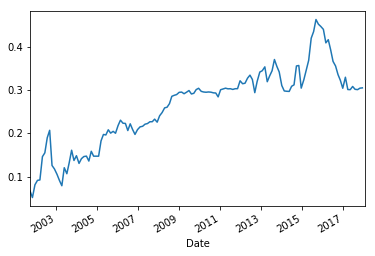

In [15]:
# Test for internal regret
ir = internal_regret_tab(w, x)
ir.plot()
plt.show()

## Small external regret to small internal regret conversion

In [45]:
def induced_matrix(delta):
    """
    Generate the A matrix from the article from a distribution on the pairs of stocks
    
    Args:
        delta (pandas.core.series.Series) : a distribution on the pairs of stocks
    Returns:
        pandas.core.frame.DataFrame :  the A matrix as a pandas DataFrame
    """
    stocks_list = []
    for pair in delta.index:
        stocks_list.append(pair.split("/")[0])
        stocks_list.append(pair.split("/")[1])
    stocks = np.unique(stocks_list)  
    A = pd.DataFrame(index=stocks, columns=stocks)
    for m in stocks:
        for i in stocks:
            if i != m:
                A.loc[m, i] = delta.loc[m + "/" + i]
    for m in stocks:
        A.loc[m, m] = - A.loc[:, m].sum()
    return A

In [46]:
def get_kernel_index(eig_vals):
    """
    From a vector of complex eigen values, find the indices of those corresponding to 0 and return their index
    
    Args:
        eig_vals (numpy.ndarray) : the vector of complex  eigen values
    Returns:
        numpy.ndarray. The array of indexes for the null eigen values
    """
    eig_vals_im, eig_vals_real = np.imag(eig_vals), np.real(eig_vals)
    eig_vals_im.setflags(write=1)
    eig_vals_real.setflags(write=1)
    eig_vals_im[abs(eig_vals_im) < 1e-6] = 0
    eig_vals_real[abs(eig_vals_real) < 1e-6] = 0
    ind_im = np.argwhere(eig_vals_im == 0)
    ind_real = np.argwhere(eig_vals_real == 0)
    null_ind = np.intersect1d(ind_im, ind_real)
    return null_ind

In [47]:
def choose_proba_distrib(vecs):
    """
    Choose a probability distribution among a set of kernel eigen vectors
    
    Args:
        vecs (numpy.ndarray) : the kernel generating vectors stacked in columns
    Returns:
        numpy.ndarray : the selected kernel vector
    """
    candidates = []
    for i in range(0, vecs.shape[1]):
        if np.allclose(np.imag(vecs[:, i]), 0):
            if np.all(vecs[:, i] >= 0):
                candidates.append(np.real(vecs[:, i]))
            elif np.all(vecs[:, i] <= 0):
                candidates.append(-np.real(vecs[:, i]))       
    if len(candidates) >= 1:
        return candidates[0] / candidates[0].sum()
    else :
        print("No probability distribution in eigen vector")
        raise np.linalg.LinAlgError

In [48]:
def fixed_point_proba(A):
    """
    Find a probability vector in the kernel of A if it exists
    
    Args:
        A (pandas.core.frame.DataFrame) : the A matrix
    Returns:
        pandas.core.series.Series. The kernel probability distribution
    """
    for col in A.columns:
        A.loc[:, col] = pd.to_numeric(A.loc[:, col])
    Amat = A.as_matrix()
    eig_vals, eig_vecs = np.linalg.eig(Amat)
    null_ind = get_kernel_index(eig_vals)
    kernel_vecs = eig_vecs[:, null_ind]
    kernel_vec_pd = pd.Series(index=A.columns, data=choose_proba_distrib(kernel_vecs))
    return kernel_vec_pd

In [49]:
def induced_portfolio(delta):
    """
    Induce portfolio on the assets from proba distribution on the pairs of assets
    
    Args:
        delta (pandas.core.series.Series) : a distribution on the pairs of stocks
    Returns:
        pandas.core.series.Series. the induced probability distribution on the stocks
    """
    A = induced_matrix(delta)
    return fixed_point_proba(A)

## BP1EXP and BP1POL

In [64]:
def delta_init(xtab) : 
    pairs_index = pairs_of_stocks(xtab)
    delta = pd.Series(data=1 / len(pairs_index), index=pairs_index)
    return delta 

In [65]:
def delta_update_exp(delta_prev, pvec, xvec, eta):
    norm_coef = 0
    delta = pd.Series(index=delta_prev.index)
    for pair in delta_prev.index:
        i, j = pair.split("/")[0], pair.split("/")[1]
        p_dot_x = (pvec * xvec).sum()
        num = np.exp(- eta * pvec.loc[i] * ((xvec[j] / p_dot_x) - (xvec[i] / p_dot_x)))
        delta.loc[pair] = delta_prev.loc[pair] * num
        norm_coef += delta_prev.loc[pair] * num
    delta *= 1 / norm_coef
    return delta

In [23]:
# Test for delta_update_exp
delta0 = delta_init(x)
delta1 = delta_update_exp(delta0, w.iloc[0, :], x.iloc[0, :], 2)
print(delta1)

aig/k      0.052258
aig/glw    0.057167
aig/txt    0.056732
aig/nke    0.051600
k/aig      0.047487
k/glw      0.054495
k/txt      0.054080
k/nke      0.049188
glw/aig    0.043410
glw/k      0.045538
glw/txt    0.049436
glw/nke    0.044964
txt/aig    0.043743
txt/k      0.045888
txt/glw    0.050198
txt/nke    0.045309
nke/aig    0.048094
nke/k      0.050452
nke/glw    0.055191
nke/txt    0.054770
dtype: float64


In [24]:
# Test for induced_matrix
amat = induced_matrix(delta1)
print(amat)

           aig        glw          k        nke        txt
aig  -0.182734  0.0571672  0.0522583  0.0515997  0.0567316
glw  0.0434097  -0.217051  0.0455382  0.0449642  0.0494362
k    0.0474873  0.0544951  -0.194136  0.0491879    0.05408
nke  0.0480935  0.0551908  0.0504517  -0.191061  0.0547703
txt   0.043743  0.0501982  0.0458878  0.0453094  -0.215018


In [25]:
# Test for induced_portfolio
induced = induced_portfolio(delta1)
print(induced)

aig    0.228773
glw    0.173718
k      0.207886
nke    0.213228
txt    0.176395
dtype: float64


In [66]:
def delta_exp(xtab, eta):
    delta0 = delta_init(xtab)
    delta_tab = pd.DataFrame(index=xtab.index, columns=delta0.index)
    ptab = pd.DataFrame(index=xtab.index, columns=xtab.columns)
    delta_tab.iloc[0, :] = delta0
    ptab.iloc[0, :] = induced_portfolio(delta_tab.iloc[0, :])
    for t in range(1, xtab.shape[0]):
        delta_tab.iloc[t, :] = delta_update_exp(delta_tab.iloc[t-1, :], ptab.iloc[t-1, :], xtab.iloc[t-1, :], eta)
        ptab.iloc[t, :] = induced_portfolio(delta_tab.iloc[t, :])
    return delta_tab, ptab

In [59]:
# Choice of stocks
x = 1 + data_returns.iloc[:200, 50:55]

In [62]:
# Test for delta_exp
eta1 = 2
delta, p_bp1exp = delta_exp(x, eta1)

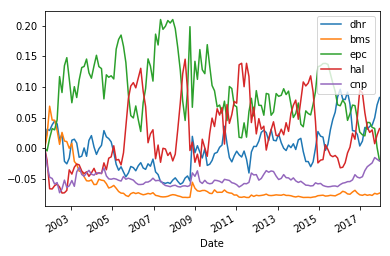

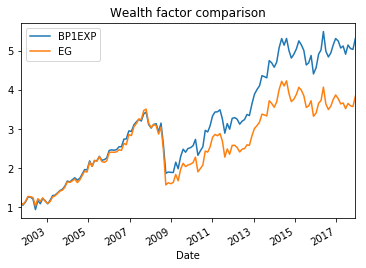

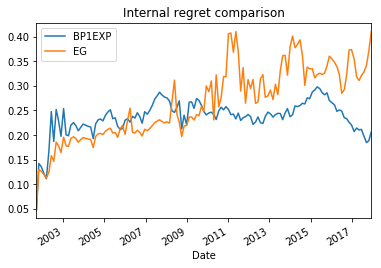

In [63]:
# Comparison between EG and BP1EXP
pinit = pd.Series(index=x.columns, data=1/len(x.columns))
p_eg = weights_eg(x, eta1, pinit)

# Comparison of weights
plt.figure()
(p_eg - p_bp1exp).plot()
plt.show()

#Comparison of wealth factor
plt.figure()
wfact_eg = wealth_factor(p_eg, x, 10)
wfact_bp1exp = wealth_factor(p_bp1exp, x, 10)
wfact_bp1exp.plot(label="BP1EXP")
wfact_eg.plot(label="EG")
plt.legend()
plt.title("Wealth factor comparison")
plt.show()

# Comparison of internal regret
plt.figure()
ir_eg = internal_regret_tab(p_eg, x)
ir_bp1exp = internal_regret_tab(p_bp1exp, x)
ir_bp1exp.plot(label="BP1EXP")
ir_eg.plot(label="EG")
plt.legend()
plt.title("Internal regret comparison")
plt.show()

## Robustness evalution by Monte Carlo

In [67]:
def stock_random_draws(returns, nstocks, ndraws):
    """
    Draw a sequence of randomly chosen sets of stocks
    
    Args:
        returns (pandas.core.frame.DataFrame) : the database of returns
        nstocks (int) : number of stock for each draws
        ndraws (int) : number of draws to perform
    Returns:
        pandas.core.frame.DataFrame. The random drawn stocks stacked in a dataframe
    """
    stocks_draws = pd.DataFrame(index=range(0, ndraws), columns=range(0, nstocks))
    for draw in range(0, ndraws):
        stock_inds = list(range(0, len(returns.columns)))
        shuffle(stock_inds)
        chosen = stock_inds[0:nstocks]
        stocks_draws.loc[draw, :] = chosen
    return stocks_draws

In [82]:
def bp1exp_mc_robustness(returns, random_draws, eta, nperiods):
    """
    Average over randomly picked sets of stocks for internal regrets and wealth factor for BP1EXP strategy
    
    Args:
        returns (pandas.core.frame.DataFrame) : the database of returns
        random_draws (pandas.core.frame.DataFrame): the data frame of random draws
        eta (float) : the eta parameter
        nperiods(int) : the number of periods to consider
    Returns:
        tuple. A tuple of pandas.core.series.Series (average_wealth_factor_series, average_internal_regret_series)
    """
    int_reg_sum_bp1exp = pd.Series(data=0, index=returns.index[:nperiods])
    wfact_sum_bp1exp = pd.Series(data=0, index=returns.index[:nperiods])
    for it in range(0, random_draws.shape[0]):
        x = 1 + returns.iloc[:nperiods, random_draws.loc[it, :]]
        delta, p_bp1exp = delta_exp(x, eta)
        wfact_bp1exp = wealth_factor(p_bp1exp, x, 10)
        ir_bp1exp = internal_regret_tab(p_bp1exp, x)
        wfact_sum_bp1exp += wfact_bp1exp
        int_reg_sum_bp1exp += ir_bp1exp
        print(it)
    return (1 / random_draws.shape[0]) * int_reg_sum_bp1exp, (1 / random_draws.shape[0]) * wfact_sum_bp1exp

In [83]:
def eg_mc_robustness(returns, random_draws, eta, nperiods):
    """
    Average over randomly picked sets of stocks for internal regrets and wealth factor for EG strategy
    
    Args:
        returns (pandas.core.frame.DataFrame) : the database of returns
        random_draws (pandas.core.frame.DataFrame): the data frame of random draws
        eta (float) : the eta parameter
        nperiods(int) : the number of periods to consider
    Returns:
        tuple. A tuple of pandas.core.series.Series (average_wealth_factor_series, average_internal_regret_series)
    """
    int_reg_sum_eg = pd.Series(data=0, index=returns.index[:nperiods])
    wfact_sum_eg = pd.Series(data=0, index=returns.index[:nperiods])
    for it in range(0, random_draws.shape[0]):
        x = 1 + returns.iloc[:nperiods, random_draws.loc[it, :]]
        pinit = pd.Series(index=x.columns, data=1/len(x.columns))
        p_eg = weights_eg(x, eta, pinit)
        wfact_eg = wealth_factor(p_eg, x, 10)
        ir_eg = internal_regret_tab(p_eg, x)
        wfact_sum_eg += wfact_eg 
        int_reg_sum_eg += ir_eg
        print(it)
    return (1 / random_draws.shape[0]) * int_reg_sum_eg, (1 / random_draws.shape[0]) * wfact_sum_eg

In [84]:
# MC averaging parameters
nstocks = 5
nperiods = data_returns.shape[0]
nit = 5
# Empirical choice of eta
eta = 2
# Choice of eta to minimize the internal regret bound in the theory
alpha = 0.3
eta_opti_eg = alpha * np.sqrt(8 * np.log(nstocks) / nperiods)
eta_opti_bp1exp = 4 * alpha * np.sqrt(np.log(nstocks) / nperiods)
print(eta_opti_bp1exp)
print(eta_opti_eg)

0.130064290501
0.0919693418035


In [85]:
# MC computations
stocks_draws = stock_random_draws(data_returns, nstocks, nit)
ir_eg, wf_eg = eg_mc_robustness(data_returns, stocks_draws, eta, nperiods)
ir_bp1exp, wf_bp1exp = bp1exp_mc_robustness(data_returns, stocks_draws, eta, nperiods)
ir_eg_opti, wf_eg_opti = eg_mc_robustness(data_returns, stocks_draws, eta_opti_eg, nperiods)
ir_bp1exp_opti, wf_bp1exp_opti = bp1exp_mc_robustness(data_returns, stocks_draws, eta_opti_bp1exp, nperiods)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


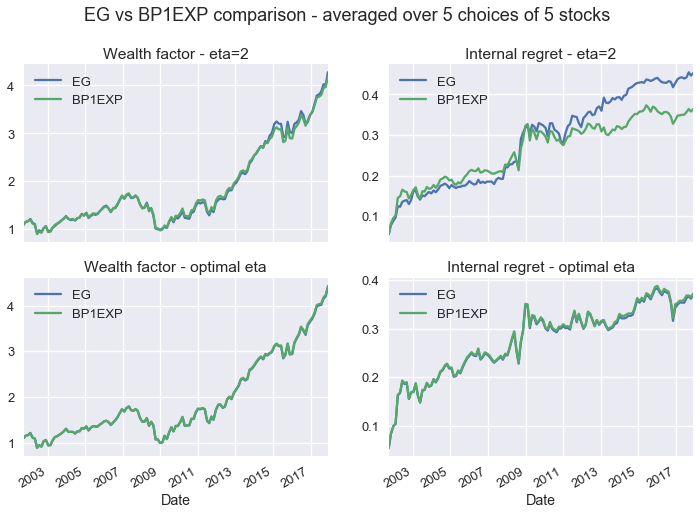

In [92]:
# Comparison plots
fig, axes = plt.subplots(2, 2, figsize=(12.0, 8.0), sharex=True)
plt.suptitle("EG vs BP1EXP comparison - averaged over " + str(nit) + " choices of " + str(nstocks) + " stocks")
axes[0, 0].set_title("Wealth factor - eta=" + str(eta))
axes[0, 1].set_title("Internal regret - eta=" + str(eta))
axes[1, 0].set_title("Wealth factor - optimal eta")
axes[1, 1].set_title("Internal regret - optimal eta")
wf_eg.plot(ax=axes[0, 0], label="EG")
wf_bp1exp.plot(ax=axes[0, 0], label="BP1EXP")
wf_eg_opti.plot(ax=axes[1, 0], label="EG")
wf_bp1exp_opti.plot(ax=axes[1, 0], label="BP1EXP")
ir_eg.plot(ax=axes[0, 1], label="EG")
ir_bp1exp.plot(ax=axes[0, 1], label="BP1EXP")
ir_eg_opti.plot(ax=axes[1, 1], label="EG")
ir_bp1exp_opti.plot(ax=axes[1, 1], label="BP1EXP")
axes[0, 0].legend()
axes[1, 0].legend()
axes[0, 1].legend()
axes[1, 1].legend()

fig.savefig(output_path + "EG_vs_BP1EXP.svg")
plt.show()